# Dataset Preprocess

<a id='toc'></a>

[Table of Contents](#toc)
1. [Load Data](#sec1)
1. [Compute POI Information](#sec2)
1. [Compute Trajectory Statistics](#sec3)
1. [Filtering out Short Trajectories](#sec4)
1. [Filtering out Trajectories with Sub-tours](#sec5)

In [1]:
% matplotlib inline

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dir_ijcai = 'data/data-ijcai15'
dir_recsys = 'data/data-recsys16'

In [3]:
fvisit = os.path.join(dir_ijcai, 'userVisits-Osak.csv')
fcoord = os.path.join(dir_ijcai, 'photoCoords-Osak.csv')
#fvisit = os.path.join(dir_ijcai, 'userVisits-Glas.csv')
#fcoord = os.path.join(dir_ijcai, 'photoCoords-Glas.csv')
#fvisit = os.path.join(dir_ijcai, 'userVisits-Edin.csv')
#fcoord = os.path.join(dir_ijcai, 'photoCoords-Edin.csv')
#fvisit = os.path.join(dir_ijcai, 'userVisits-Toro.csv')
#fcoord = os.path.join(dir_ijcai, 'photoCoords-Toro.csv')

In [4]:
suffix = fvisit.split('-')[-1].split('.')[0]

In [5]:
fpoi = os.path.join(dir_recsys, 'poi-' + suffix + '.csv')
ftraj_all = os.path.join(dir_recsys, 'traj-all-' + suffix + '.csv')
ftraj_noshort = os.path.join(dir_recsys, 'traj-noshort-' + suffix + '.csv')
ftraj_nofew = os.path.join(dir_recsys, 'traj-nofew-' + suffix + '.csv')

<a id='sec1'></a>

## 1. Load Data

Load user visit data and photo coordinates.

In [6]:
visits = pd.read_csv(fvisit, sep=';')
coords = pd.read_csv(fcoord, sep=';')
assert(visits.shape[0] == coords.shape[0])
visits = pd.merge(visits, coords, on='photoID') # merge data frames according to column 'photoID'
visits.head()

,photoID,userID,dateTaken,poiID,poiTheme,poiFreq,seqID,photoLon,photoLat
0,6656416589,10297518@N00,1277719324,20,Entertainment,514,1,135.500597,34.668722
1,6656418463,10297518@N00,1277719344,20,Entertainment,514,1,135.500447,34.668502
2,6656420371,10297518@N00,1277719541,20,Entertainment,514,1,135.500447,34.668502
3,6656421479,10297518@N00,1277719558,20,Entertainment,514,1,135.500447,34.668502
4,6656422763,10297518@N00,1277719573,20,Entertainment,514,1,135.500447,34.668502


In [7]:
num_photo = visits['photoID'].unique().shape[0]
num_user = visits['userID'].unique().shape[0]
num_poi = visits['poiID'].unique().shape[0]
num_traj = visits['seqID'].unique().shape[0]
pd.DataFrame({'#photo': num_photo, '#user': num_user, '#poi': num_poi, '#traj': num_traj, \
              '#photo/user': num_photo/num_user, '#traj/user': num_traj/num_user}, index=[str(suffix)])

,#photo,#photo/user,#poi,#traj,#traj/user,#user
Osak,7747,17.215556,27,1115,2.477778,450


<a id='sec2'></a>

## 2. Compute POI Information

Compute POI (Longitude, Latitude) as the average coordinates of the assigned photos.

In [8]:
poi_coords = visits[['poiID', 'photoLon', 'photoLat']].groupby('poiID').mean()
poi_coords.reset_index(inplace=True)
poi_coords.rename(columns={'photoLon':'poiLon', 'photoLat':'poiLat'}, inplace=True)

Extract POI category.

In [9]:
poi_cat = visits[['poiID', 'poiTheme']].groupby('poiID').first()
poi_cat.reset_index(inplace=True)

In [10]:
poi_all = pd.merge(poi_cat, poi_coords, on='poiID')
poi_all.set_index('poiID', inplace=True)
poi_all.rename(columns={'poiTheme':'poiCat'}, inplace=True)
poi_all

,poiCat,poiLon,poiLat
poiID,,,
1,Amusement,135.428938,34.654792
2,Amusement,135.430627,34.656145
3,Amusement,135.508558,34.652423
4,Amusement,135.433627,34.664758
5,Amusement,135.499894,34.703680
6,Amusement,135.490133,34.705323
7,Park,135.506961,34.692664
8,Park,135.525824,34.686534
9,Park,135.488806,34.612893


Scatter plot of POI coordinates.

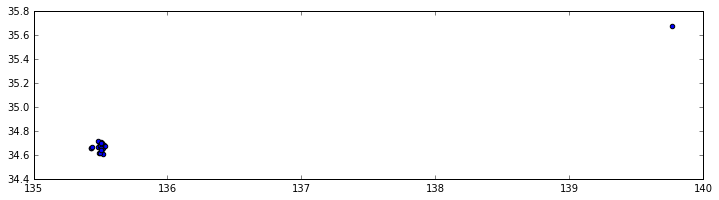

In [11]:
height = 3
ratio = (poi_all['poiLon'].max() - poi_all['poiLon'].min()) / (poi_all['poiLat'].max() - poi_all['poiLat'].min())
plt.figure(figsize=[height * np.round(ratio), height])
plt.scatter(poi_all['poiLon'], poi_all['poiLat'])

Save POI information to CSV file.

In [12]:
#poi_all.to_csv(fpoi, index=True)

<a id='sec3'></a>

## 3. Compute Trajectory Statistics

Compute trajectories information including simple statistics such as length (#POIs), POI start time, POI endtime, etc.

In [13]:
def calc_traj_df(seqid, visits):
    """Compute trajectories info, taking care of trajectories that contain sub-tours"""
    traj_df = visits[visits['seqID'] == seqid].copy()
    traj_df.sort_values(by='dateTaken', ascending=True, inplace=True)
    df_ = pd.DataFrame(columns=['poiID', 'startTime', 'endTime', '#photo'])
    assert(traj_df.shape[0] > 0)
    ix = traj_df.index[0]
    j = 0
    df_.loc[j] = [traj_df.loc[ix, 'poiID'], traj_df.loc[ix, 'dateTaken'], traj_df.loc[ix, 'dateTaken'], 1]
    for i in range(1, traj_df.shape[0]):
        ix = traj_df.index[i]
        if traj_df.loc[ix, 'poiID'] == df_.loc[j, 'poiID']:
            df_.loc[j, 'endTime'] = traj_df.loc[ix, 'dateTaken']
            df_.loc[j, '#photo'] += 1
        else:
            j += 1
            df_.loc[j] = [traj_df.loc[ix, 'poiID'], traj_df.loc[ix, 'dateTaken'], traj_df.loc[ix, 'dateTaken'], 1]
    df_['userID'] = traj_df.loc[traj_df.index[0], 'userID']
    df_['trajID'] = seqid
    df_['trajLen'] = df_.shape[0]
    return df_

In [36]:
traj_all[['trajID', 'trajLen']].copy().groupby('trajID').first().sum().values[0]

1419

In [14]:
traj_all = pd.DataFrame(columns=['userID', 'trajID', 'poiID', 'startTime', 'endTime', '#photo', 'trajLen'])
for seqid in sorted(visits['seqID'].unique().tolist()):
    traj_df = calc_traj_df(seqid, visits)
    assert(int(traj_df['#photo'].sum()) >= traj_df.loc[0, 'trajLen'])
    traj_all = traj_all.append(traj_df, ignore_index=True)
traj_all.head()

,#photo,endTime,poiID,startTime,trajID,trajLen,userID
0,6.0,1.277721e+09,20.0,1.277719e+09,1.0,1.0,10297518@N00
1,2.0,1.382608e+09,21.0,1.382608e+09,2.0,4.0,10307040@N08
2,1.0,1.382608e+09,8.0,1.382608e+09,2.0,4.0,10307040@N08
3,9.0,1.382609e+09,22.0,1.382608e+09,2.0,4.0,10307040@N08
4,1.0,1.382609e+09,6.0,1.382609e+09,2.0,4.0,10307040@N08


In [15]:
traj_all.dtypes

#photo       float64
endTime      float64
poiID        float64
startTime    float64
trajID       float64
trajLen      float64
userID        object
dtype: object

In [16]:
int_cols = ['trajID', 'poiID', 'trajLen', 'startTime', 'endTime', '#photo']
traj_all[int_cols] = traj_all[int_cols].astype(np.int, copy=False)

Sanity check.

In [17]:
print(np.all(traj_all['trajLen'] >= 1))
print(np.all(traj_all['#photo'] >= 1))
print(np.all(traj_all['startTime'] <= traj_all['endTime']))

True
True
True


In [18]:
traj_all['poiDuration'] = traj_all['endTime'] - traj_all['startTime']
print(traj_all.shape)
traj_all.head()

(1419, 8)


,#photo,endTime,poiID,startTime,trajID,trajLen,userID,poiDuration
0,6,1277720832,20,1277719324,1,1,10297518@N00,1508
1,2,1382607774,21,1382607761,2,4,10307040@N08,13
2,1,1382607812,8,1382607812,2,4,10307040@N08,0
3,9,1382608628,22,1382607879,2,4,10307040@N08,749
4,1,1382608644,6,1382608644,2,4,10307040@N08,0


In [19]:
traj_all.dtypes

#photo          int64
endTime         int64
poiID           int64
startTime       int64
trajID          int64
trajLen         int64
userID         object
poiDuration     int64
dtype: object

In [20]:
# ERROR: this method doesn't consider sub-tours in trajectory
#traj_all = traj[['userID', 'seqID', 'poiID', 'dateTaken']].copy().groupby(['userID', 'seqID', 'poiID'])\
#           .agg([np.min, np.max, np.size])  
#traj_all.columns = traj_all.columns.droplevel()
#traj_all.reset_index(inplace=True)
#traj_all.rename(columns={'amin':'startTime', 'amax':'endTime', 'size':'#photo', 'seqID':'trajID'}, inplace=True)

Save trajectories and the associated stats to CSV files.

In [21]:
#traj_all.to_csv(ftraj_all, index=False)

<a id='sec4'></a>

## 4. Filtering out Short Trajectories

Filtering out short trajectories, i.e., trajectories with only 1 or 2 POIs.

In [22]:
traj_noshort = traj_all[traj_all['trajLen'] >= 3].copy()
print(traj_noshort.shape)
traj_noshort.head()

(246, 8)


,#photo,endTime,poiID,startTime,trajID,trajLen,userID,poiDuration
1,2,1382607774,21,1382607761,2,4,10307040@N08,13
2,1,1382607812,8,1382607812,2,4,10307040@N08,0
3,9,1382608628,22,1382607879,2,4,10307040@N08,749
4,1,1382608644,6,1382608644,2,4,10307040@N08,0
5,8,1364287231,21,1364286248,3,3,10340578@N06,983


In [23]:
traj_noshort['#photo'].sum()

1595

Save trajectories and the associated stats without short trajectories to CSV files.

In [24]:
#traj_noshort.to_csv(ftraj_noshort, index=False)

<a id='sec5'></a>

## 5. Filtering out Users with Few Trajectories

Filtering out users (and related trajectories) with few trajectories, e.g. less than $5$ trajectories.

In [25]:
MIN_N = 5

In [26]:
user_list = []

In [27]:
for user in sorted(traj_all['userID'].unique().tolist()):
    ntraj = traj_all[traj_all['userID'] == user]['trajID'].unique().shape[0]
    if ntraj >= MIN_N:
        user_list.append(user)

In [28]:
traj_nofew = traj_all[traj_all['userID'].isin(user_list)].copy()
print(traj_nofew.shape)
traj_nofew.head()

(577, 8)


,#photo,endTime,poiID,startTime,trajID,trajLen,userID,poiDuration
39,2,1324897703,20,1324897657,20,1,12452841@N00,46
40,2,1325017685,20,1325017611,21,2,12452841@N00,74
41,1,1325022901,27,1325022901,21,2,12452841@N00,0
42,2,1397814456,21,1397807372,22,1,12452841@N00,7084
43,6,1397866532,20,1397866441,23,3,12452841@N00,91


Save trajectories.

In [29]:
#traj_nofew.to_csv(ftraj_nofew, index=False)

Sanity check.

In [30]:
for user in sorted(traj_nofew['userID'].unique().tolist()):
    udf = traj_nofew[traj_nofew['userID'] == user]
    assert(udf['trajID'].unique().shape[0] >= MIN_N)
print('Checking finished.')

Checking finished.
